__Goal__: Test inversion

    After simulate a source galaxy and deflect it, it's time to test the inversion!
    
We do that using two different approaches:
    1. Using the MGE decomposition, as we do in the simulation
    2. Using the pseudo ellpitical NFW analytical model.

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_4/Simulation_Data/"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)        #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("eNFW.txt", unpack=True)             #DM component

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5                                                          #Scale radius of DM [arcsec]
ml     = 5.00                                                          #mass to light ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

### Reading Data

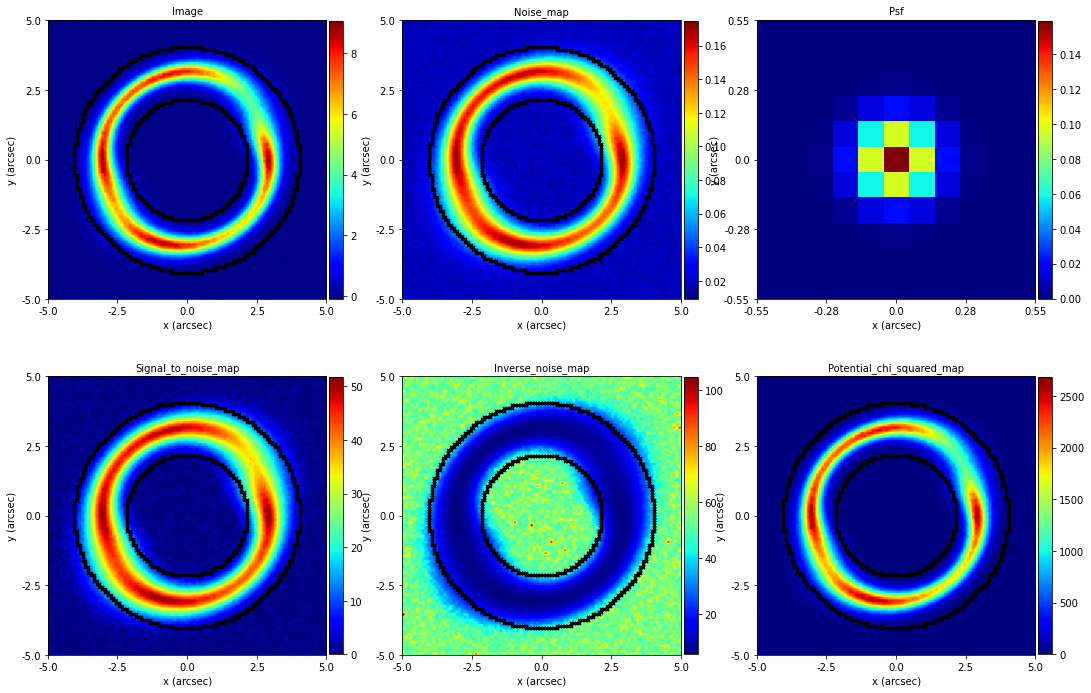

In [4]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask = al.Mask.circular_annular(centre=(0.0, 0.), inner_radius=2.1, outer_radius=4.1,
                              pixel_scales=imaging.pixel_scales, shape_2d=imaging.shape_2d) #Create a mask

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=False),                         #Plot
)

## Starting model only MGE
Here we define the lens mass profile. This frist model uses the MGE eNFW decompostion.

In [5]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()


#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm =kappa_ * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [6]:
#Now we set the tracer to the source galaxy

start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_s)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 7.997297403999255


We'll use the rectangular _Pixelization_ and _Mapper_ to perform the inversion.

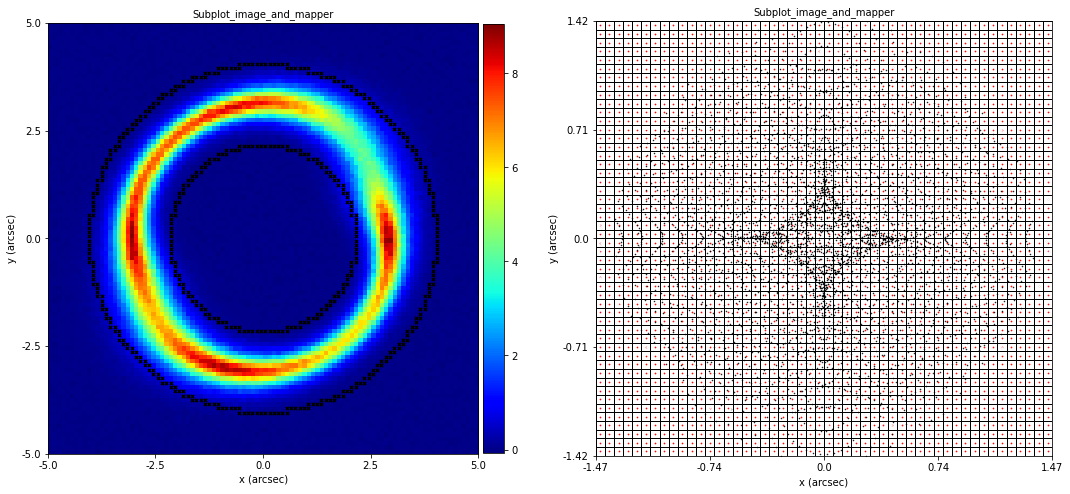

In [7]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we're going to use our _Mapper_ to invert the image using an _Inversion_.

In [8]:
start = clock()
inversion = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=4.5),
)
print("Elapsed time", clock() - start)

Elapsed time 0.866560941998614


Our _Inversion_ has a reconstructed image and _Pixeilzation_, whcih we can plot using an _Inversion_ plotter

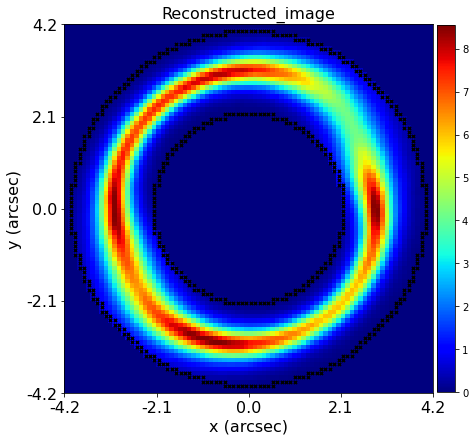

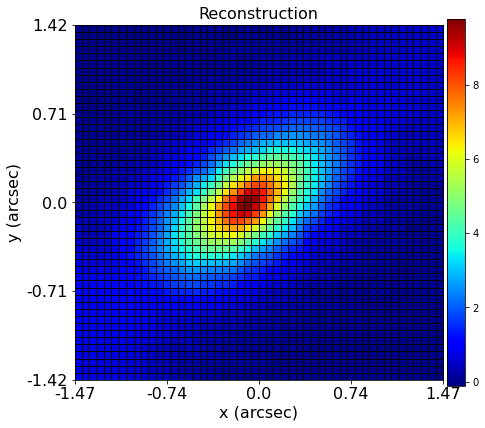

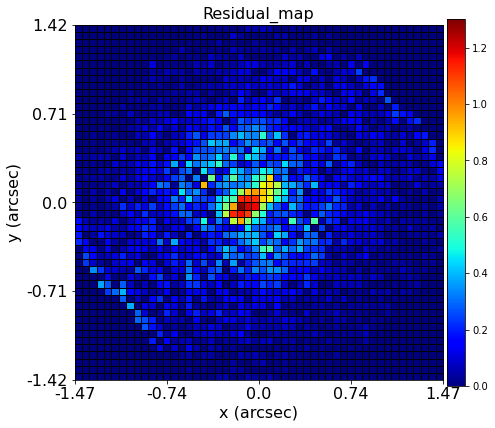

In [9]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_pixelization_grid=False, inversion_border=False)
)

aplt.Inversion.residual_map(inversion, include=aplt.Include(inversion_pixelization_grid=False,
                                                            inversion_border=False))

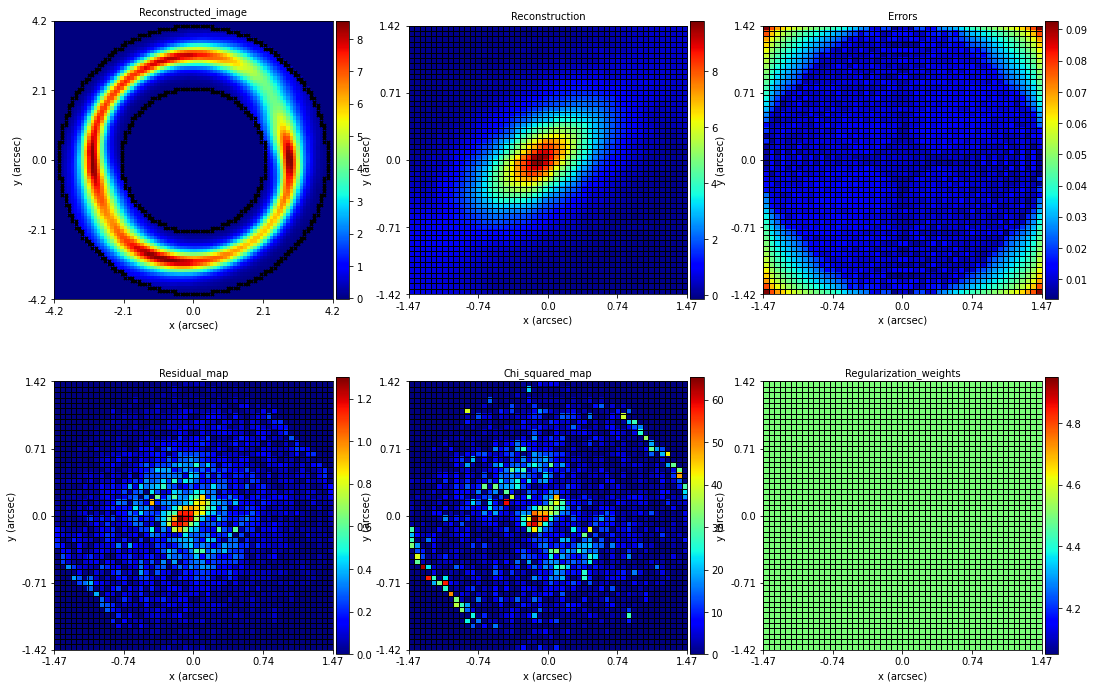

In [10]:
output=aplt.Output(path=data_folder,filename="Rectangular_Inversion_OnlyMGE", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.Inversion.subplot_inversion(inversion,include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False), sub_plotter=plotter)

#Plot
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False))

## Starting model with pENFW
Here we define the lens mass profile. This  model uses the pseudo ellipical NFW.

A good aproximation for the axial ratio of the potential is assume that the ellipticity of mass is about twice the ellipticity of the potential.

Actually, we have, for small $\epsilon$ [0, 0.25] the approximation $\epsilon \approx \epsilon_\phi$. And then

$\epsilon_\Sigma \approx 2\epsilon_\phi$ and $q_\phi = \frac{1+q_\Sigma}{2}$. Or in terms of $\epsilon$:

$\epsilon = \frac{1 - q_\Sigma}{2}$

Beside that, we assume that the major axis is along the x-axis, so we define the position angle (phi above) as zero.

In [11]:
e = (1 - qobs_dm[0])/2.          #ellipticity of the potential.
print("Ellipticity of the Potential:", e)
print("Ellipticity of Density Mass:", 1 - qobs_dm[0])

Ellipticity of the Potential: 0.07500000000000001
Ellipticity of Density Mass: 0.15000000000000002


In [12]:
#MGE mass profile

#Initializing
pENFW = al.mp.dark_mass_profiles.pseudoEllipticalNFW(kappa_s=kappa_, scale_radius=r_s, e=e) #pseudo elliptical NFW

mass_profile2 = al.mp.MGE()                            #MGE mass model
mass_profile2.Analytic_Model(analytic_profile=pENFW)   #Include the analytical pENFW

#Components
mass_profile2.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh) #DON'T INCLUDE THE MGE PARAMETRIZATION OF DM

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy2 = al.Galaxy(
    redshift=z_l,
    mass=mass_profile2,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [13]:
#Now we set the tracer to the source galaxy

start = clock()

tracer2 = al.Tracer.from_galaxies(galaxies=[lens_galaxy2, al.Galaxy(redshift=z_s)])
source_plane_grid2 = tracer2.traced_grids_of_planes_from_grid(grid=masked_image.grid)[1]

print("Elapsed time", clock() - start)

Elapsed time 2.5161121120036114


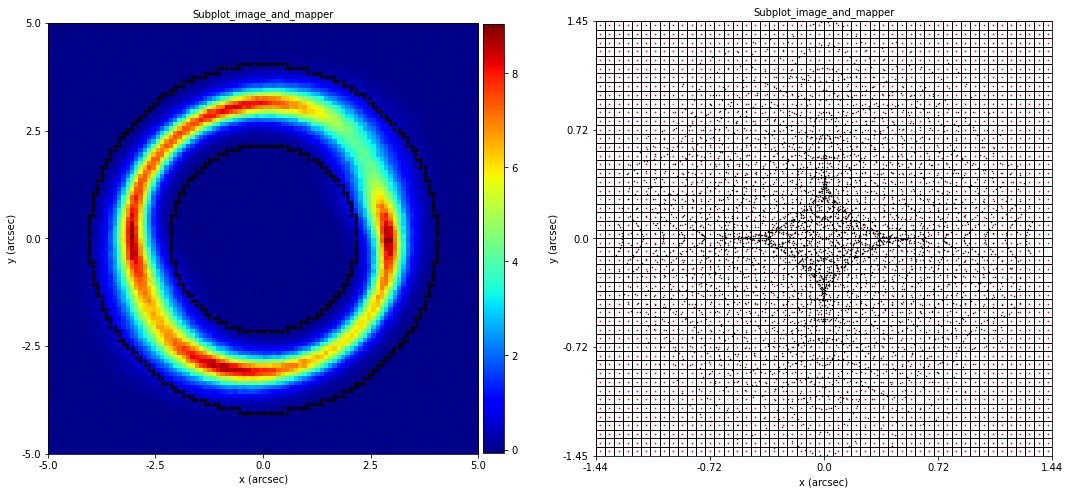

In [14]:
rectangular2 = al.pix.Rectangular(shape=(50, 50))

mapper2 = rectangular2.mapper_from_grid_and_sparse_grid(grid=source_plane_grid2)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper2,
    include=aplt.Include(mask=True, inversion_grid=True),
)

In [15]:
start = clock()
inversion2 = al.Inversion(
    masked_dataset=masked_image,
    mapper=mapper2,
    regularization=al.reg.Constant(coefficient=4.5),
)
print("Elapsed time", clock() - start)

Elapsed time 0.8449081529979594


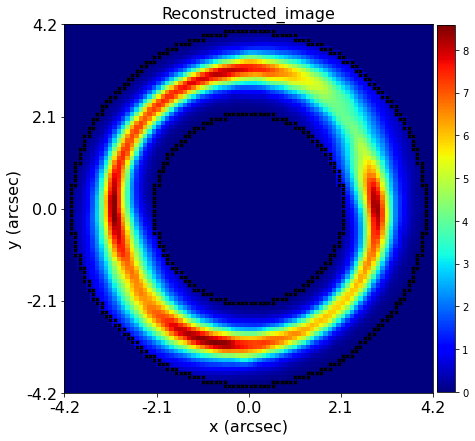

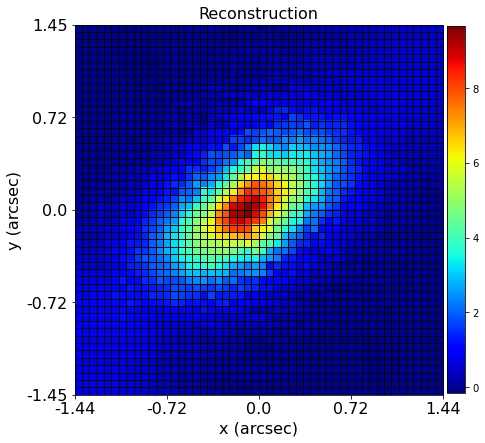

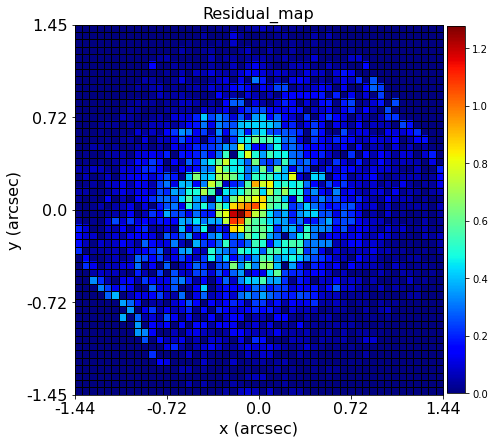

In [16]:
aplt.Inversion.reconstructed_image(inversion=inversion2, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion2, include=aplt.Include(inversion_pixelization_grid=False, inversion_border=False)
)

aplt.Inversion.residual_map(inversion2, include=aplt.Include(inversion_pixelization_grid=False,
                                                            inversion_border=False))

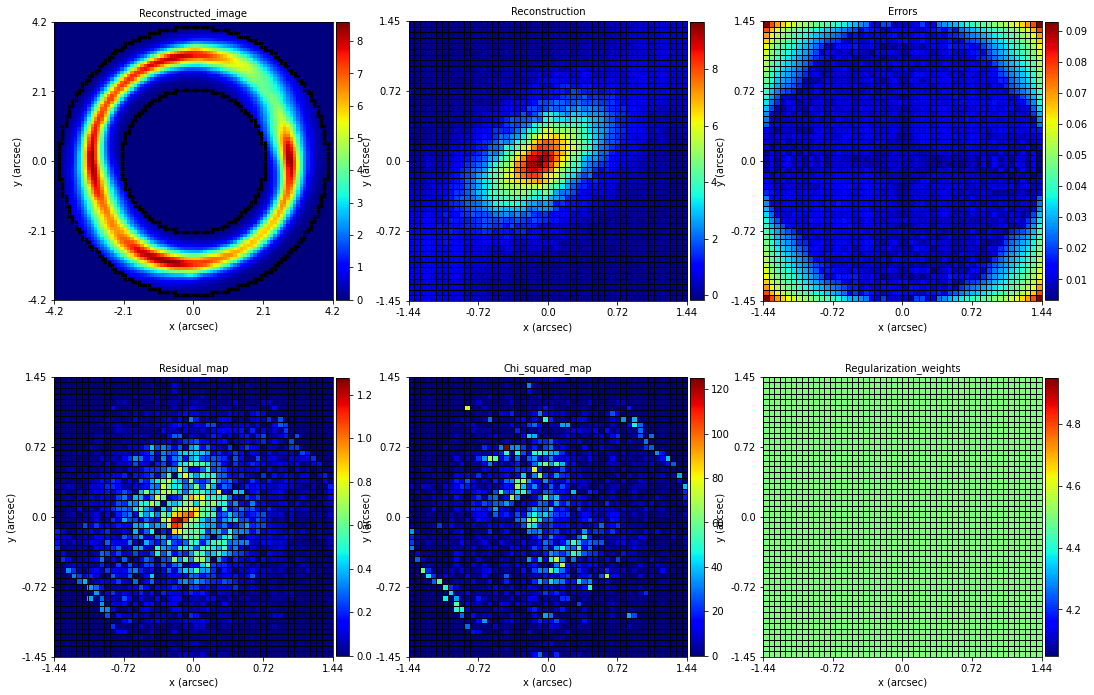

In [17]:
output=aplt.Output(path=data_folder,filename="Rectangular_Inversion_AnalyticalpENFW", format="png")

plotter = aplt.SubPlotter(
    figure=aplt.Figure(figsize=(15, 15)),
    ticks=aplt.Ticks(ysize=5, xsize=8),
    labels=aplt.Labels(ysize=12, xsize=12, titlesize=12),output=output
)
#Save
aplt.Inversion.subplot_inversion(inversion2,include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False), sub_plotter=plotter)

#Plot
aplt.Inversion.subplot_inversion(inversion2, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False))

## Comparing Differences

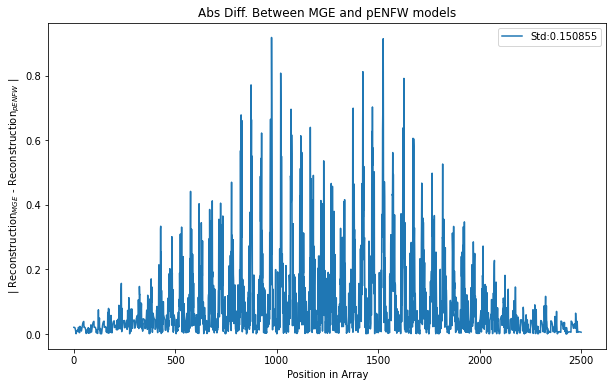

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

std = np.std(inversion.reconstruction - inversion2.reconstruction)
plt.plot( abs(inversion.reconstruction - inversion2.reconstruction), label="Std:%f"%std )
plt.ylabel("| Reconstruction$_{MGE}$ - Reconstruction$_{pENFW}$ |")
plt.xlabel("Position in Array")
plt.title("Abs Diff. Between MGE and pENFW models")
plt.legend()